## Bayesian Hierarchical Model Example
### K-Drama Ratings
02-2023

#### Background:

Example approach copied from these resources: 
- https://bayesball.github.io/BOOK/bayesian-hierarchical-modeling.html
- https://bayesball.github.io/BOOK/bayesian-hierarchical-modeling.html#example-ratings-of-animation-movies

A sample from a tv database was collected on K-drama ratings for 100 different tv dramas released 2003-2021. There are 14 different genres and each drama has a single rating, which is an aggregate of all viewer ratings of that drama. The ratings are likely affected by the type of genre, as some genres are generally favored by the audience or have more options available for viewers to compare against.

#### Business Question:
- What is the expected average rating for a given genre?
- I have money to invest into a new drama series. Which genre would be a smart decision to invest in?


#### Data:
- Let  Yij denote the overall viewer rating of drama i in genre j
    e.g. Yij = 9.0 Happiness | Action
- Viewer ratings are continuous
- Genre is our grouping variable
- Genre categorization is imprecise since most dramas fall into multiple genres


#### Posterior Distribution:
Viewer Rating ~ Normal(μj, σ)

where μj = mean of viewer ratings per each genre j
and σ = a common standard deviation of viewer ratings shared across all genres

_Ituition:_

The μ and σ values for each genre a priori are related and come from the same distribution, but could be very different if the standard deviation of the distribution is wide. 


#### Prior Distribution:
μj ~ Normal(x, y)

σ^2 ~ InverseGamma(a,b)

_Ituition:_

The prior distribution is a model for all average viewer ratings, corresponding to each particular genres within K-drama television, with these 14 genres being a sample.

The prior Normal(x, y) is a communal prior for the means μj which induces sharing of information across ratings from different genres. Because we specify x and y as random variables, this allows each genre to have its own mean estimate and variation between genres. 

The model uses a shared σ for all genres which also induces sharing of information, but is different in that it pools all the genres together, not allowing genres to have their own σ. With this setup, we cannot learn about the differences and similarities among the genre's standard deviation of average rating.



#### Hyper Prior:

x ~ Normal(c,d)

y^2 ~ InverseGamma(e,f)

_Ituition:_

The hyper prior distributions allow us to learn about μj's distribution in the prior and provides information about the population of viewer rating means per genre.

In [65]:
# import packages
import numpy as np
#import statistics
#import math
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

colors = ['#50CCDE','#87E0CD','#AFE28A', '#E1929B', '#519485','#B570BA','#7c3e81' ]

In [66]:
# Working Directory
os.getcwd()

'C:\\Users\\anneg\\OneDrive - Logic20 20 Inc\\Documents\\Python Scripts'

In [67]:
#### DATA
data=pd.read_csv(r'top100_kdrama.csv')

#### The main columns we will focus on are _Genre_ and _Rating_

In [69]:
# explore data
data.head()

,Name,Year of release,Aired Date,Aired On,Number of Episode,Network,Duration,Content Rating,Synopsis,Cast,Genre,Tags,Rank,Rating
0,Move to Heaven,2021,"May 14, 2021",Friday,10,Netflix,52 min.,18+ Restricted (violence & profanity),Geu Roo is a young autistic man. He works for ...,"Lee Je Hoon, Tang Jun Sang, Hong Seung Hee, Ju...","Life, Drama, Family","Autism, Uncle-Nephew Relationship, Death, Sava...",#1,9.2
1,Hospital Playlist,2020,"Mar 12, 2020 - May 28, 2020",Thursday,12,"Netflix, tvN",1 hr. 30 min.,15+ - Teens 15 or older,The stories of people going through their days...,"Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...","Friendship, Romance, Life, Medical","Strong Friendship, Multiple Mains, Best Friend...",#2,9.1
2,Flower of Evil,2020,"Jul 29, 2020 - Sep 23, 2020","Wednesday, Thursday",16,tvN,1 hr. 10 min.,15+ - Teens 15 or older,Although Baek Hee Sung is hiding a dark secret...,"Lee Joon Gi, Moon Chae Won, Jang Hee Jin, Seo ...","Thriller, Romance, Crime, Melodrama","Married Couple, Deception, Suspense, Family Se...",#3,9.1
3,Hospital Playlist 2,2021,"Jun 17, 2021 - Sep 16, 2021",Thursday,12,"Netflix, tvN",1 hr. 40 min.,15+ - Teens 15 or older,Everyday is extraordinary for five doctors and...,"Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...","Friendship, Romance, Life, Medical","Workplace, Strong Friendship, Best Friends, Mu...",#4,9.1
4,My Mister,2018,"Mar 21, 2018 - May 17, 2018","Wednesday, Thursday",16,tvN,1 hr. 17 min.,15+ - Teens 15 or older,Park Dong Hoon is a middle-aged engineer who i...,"Lee Sun Kyun, IU, Park Ho San, Song Sae Byuk, ...","Psychological, Life, Drama, Family","Age Gap, Nice Male Lead, Strong Female Lead, H...",#5,9.1


In [70]:
# create simplified 'Genre' column
data['genre_simple']=data['Genre'].str.split(',').str[0]

#### Note that the simplied genre category (taking the first value from _Genre_) is not a perfect system.
e.g. Hotel Del Luna is not a horror

Better ways to classify genre could be cross-reference multiple data sources and use mode category, or use an unsupervised learning approach to cluster dramas into similar groupings.

In [71]:
data.iloc[[7,12,14,18,21,26,49,55]]


,Name,Year of release,Aired Date,Aired On,Number of Episode,Network,Duration,Content Rating,Synopsis,Cast,Genre,Tags,Rank,Rating,genre_simple
7,It's Okay to Not Be Okay,2020,"Jun 20, 2020 - Aug 9, 2020","Saturday, Sunday",16,"Netflix, tvN",1 hr. 15 min.,15+ - Teens 15 or older,Moon Gang Tae is a community health worker at ...,"Kim Soo Hyun, Seo Yea Ji, Oh Jung Se, Park Gyu...","Psychological, Comedy, Romance, Drama","Sibling Relationship, Melodrama, Mental Health...",#8,9.0,Psychological
12,Happiness,2021,"Nov 5, 2021 - Dec 11, 2021","Friday, Saturday",12,tvN,1 hr. 5 min.,15+ - Teens 15 or older,A deadly new strain of a virus is spreading th...,"Han Hyo Joo, Park Hyung Sik, Jo Woo Jin, Lee ...","Action, Thriller, Drama, Fantasy","Disease, Strong Female Lead, Survival, Virus, ...",#13,9.0,Action
14,Crash Landing on You,2019,"Dec 14, 2019 - Feb 16, 2020","Sunday, Saturday",16,"Netflix, tvN",1 hr. 25 min.,15+ - Teens 15 or older,"After getting into a paragliding accident, Sou...","Hyun Bin, Son Ye Jin, Seo Ji Hye, Kim Jung Hyu...","Military, Comedy, Romance, Political","North And South Korea, Star Crossed Lovers, Lo...",#15,9.0,Military
18,Healer,2014,"Dec 8, 2014 - Feb 10, 2015","Monday, Tuesday",20,KBS2,60 min.,15+ - Teens 15 or older,Seo Jung Hoo is a special kind of night courie...,"Ji Chang Wook, Park Min Young, Yoo Ji Tae, Kim...","Action, Thriller, Mystery, Romance","Double Identity, Hidden Identity, Smart Male L...",#19,8.9,Action
21,Hometown Cha-Cha-Cha,2021,"Aug 28, 2021 - Oct 17, 2021","Saturday, Sunday",16,"Netflix, tvN",1 hr. 20 min.,15+ - Teens 15 or older,Hometown Cha-Cha-Cha is a love story set in th...,"Shin Min Ah, Kim Seon Ho, Lee Sang Yi, In Gyo ...","Comedy, Romance, Life","Rural Village, Dentist, Healing, Kind-hearted ...",#22,8.8,Comedy
26,Weightlifting Fairy Kim Bok Joo,2016,"Nov 16, 2016 - Jan 11, 2017","Wednesday, Thursday",16,MBC,60 min.,15+ - Teens 15 or older,Bok Joo is a weightlifter who is pursuing her ...,"Lee Sung Kyung, Nam Joo Hyuk, Lee Jae Yoon, Ky...","Comedy, Romance, Youth, Sports","College Life, Dream, Friends To Lovers, Weight...",#27,8.8,Comedy
49,Hotel del Luna,2019,"Jul 13, 2019 - Sep 1, 2019","Saturday, Sunday",16,tvN,1 hr. 20 min.,15+ - Teens 15 or older,Nestled deep in the heart of Seoul’s thriving ...,"IU, Yeo Jin Goo, Shin Jung Keun, Bae Hae Seon,...","Horror, Comedy, Romance, Fantasy","Boss-Employee Relationship, Immortal, Strong F...",#50,8.7,Horror
55,Strong Woman Do Bong Soon,2017,"Feb 24, 2017 - Apr 15, 2017","Friday, Saturday",16,jTBC,1 hr. 7 min.,15+ - Teens 15 or older,"Do Bong Soon is a petite, unemployed woman who...","Park Bo Young, Park Hyung Sik, Kim Ji Soo, Jun...","Action, Thriller, Comedy, Romance, Drama, ...","Strong Female Lead, Female Lead Action Scenes,...",#56,8.7,Action


#### Descriptive Statistics / EDA of dataset:

In [72]:
data.describe()

,Year of release,Number of Episode,Rating
count,100.000000,100.000000,100.000000
mean,2017.970000,19.070000,8.723000
std,2.869044,12.378096,0.174573
min,2003.000000,6.000000,8.500000
25%,2017.000000,16.000000,8.600000
50%,2019.000000,16.000000,8.700000
75%,2020.000000,20.000000,8.800000
max,2021.000000,100.000000,9.200000


In [6]:
print("Number of obs: ", data.shape[0])
print("Average Rating: ", data.Rating.mean())
print("Min Rating: ", data.Rating.min())
print("Max Rating: ", data.Rating.max())

Number of obs:  100
Average Rating:  8.723000000000006
Min Rating:  8.5
Max Rating:  9.2


#### Note the data limitations for some of the genre categories (e.g. _Food_, _Drama_). Bayesian is a great approach for small datasets.

It would be difficult to learn much about the mean rating for genres with only 1 observation. Here, we can improve the estimate of the mean rating by using hierarchical modeling, which utilizes some pooling of the entire dataset.

In [73]:
# Genre frequency list
data['genre_simple'].value_counts()

Thriller         21
Action           19
Comedy           15
Friendship        9
Mystery           8
Historical        7
Psychological     6
Life              3
Horror            3
Romance           3
Military          2
Business          2
Drama             1
Food              1
Name: genre_simple, dtype: int64

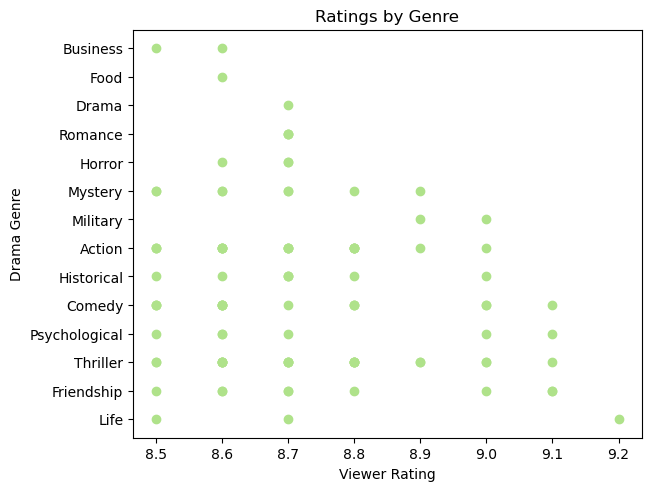

In [74]:
plt.scatter(x=data.Rating, y=data.genre_simple, color=colors[2])
plt.xlabel("Viewer Rating")
plt.ylabel("Drama Genre")
plt.title("Ratings by Genre")
plt.show()

<AxesSubplot:xlabel='Rating', ylabel='genre_simple'>

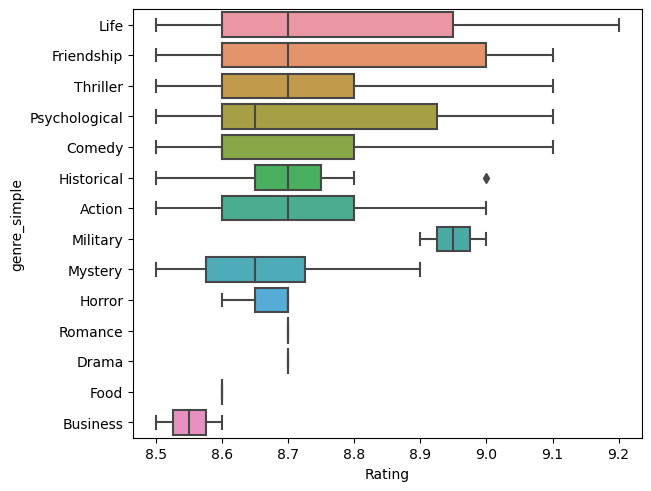

In [75]:
sns.boxplot(data = data, y = "genre_simple", x = "Rating")

In [76]:
"""
(
    data.groupby("genre_simple")["Rating"]
    .mean()
    .plot(
        kind="bar",
        title="Average magnitude of viewer ratings by genre",
        yerr=data.groupby("genre_simple")["Rating"].std(),
        color=colors[3],
        ylim=(data.Rating.min() - 1, 10),
    )
    .set_ylabel("Average Rating Value")
);
"""

'\n(\n    data.groupby("genre_simple")["Rating"]\n    .mean()\n    .plot(\n        kind="bar",\n        title="Average magnitude of viewer ratings by genre",\n        yerr=data.groupby("genre_simple")["Rating"].std(),\n        color=colors[3],\n        ylim=(data.Rating.min() - 1, 10),\n    )\n    .set_ylabel("Average Rating Value")\n);\n'

In [77]:
means = data.groupby('genre_simple')['Rating'].mean().reset_index()
sds = data.groupby('genre_simple')['Rating'].std().reset_index()
ns = data.groupby('genre_simple')['Rating'].size().reset_index()

In [78]:
# Table of rating stats by genre
genre_stats=pd.merge(pd.merge(means,sds, on='genre_simple', how='left'), ns, on='genre_simple', how='left').rename(columns = {'Rating_x':'Mean','Rating_y':'SD','Rating':'N'})
genre_stats

,genre_simple,Mean,SD,N
0,Action,8.694737,0.139338,19
1,Business,8.550000,0.070711,2
2,Comedy,8.713333,0.195911,15
3,Drama,8.700000,NaN,1
4,Food,8.600000,NaN,1
5,Friendship,8.788889,0.226078,9
6,Historical,8.714286,0.157359,7
7,Horror,8.666667,0.057735,3
8,Life,8.800000,0.360555,3
9,Military,8.950000,0.070711,2


### The Model:

- import PyMC package to faciliate the model setup and the MCMC approach to parameter estimation
- reiterate the posterior distribution function, prior distributions, and hyperprior distributions
- The model = the complete hierarchical framework of posterior, priors, and hyper-priors
- The likelihood function = specified shape of the observation data; the posterior distribution; e.g. Viewer Rating ~ Normal(μj, σ^2)
- PyMC runs on an PyTensor graph under the hood


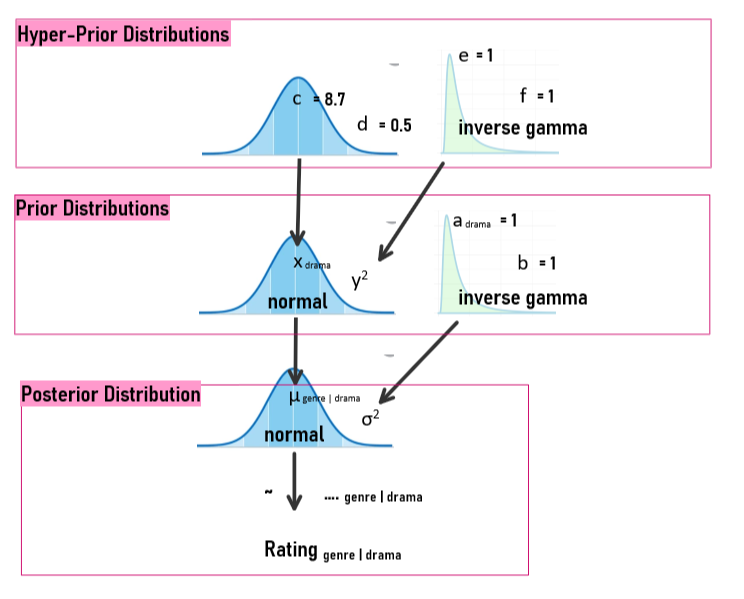

In [79]:
import pymc as pm #package to run the MCMC sampling algorithm
import arviz as az #package for exploratory analysis of Bayesian models
from pymc import model_to_graphviz
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.0.2


In [80]:
import pytensor.tensor as pt

In [81]:
plt.rcParams["figure.constrained_layout.use"] = True
genre_idx, genres = pd.factorize(data["genre_simple"], sort=True)
coords = {"genre": genres}

#### Weakly Informative Priors, with NUTS sampler:

In [82]:
# priors
# μj ~ Normal(x, y)
# σ^2 ~ InverseGamma(a,b)
a=1
b=1

# Hyperpriors:
# x ~ Normal(c,d)
# y^2 ~ InverseGamma(e,f)
c=8.7
d=.5
e=1
f=1

In [84]:
with pm.Model(coords=coords) as model:
    # constant data
    genre_cat = pm.ConstantData("genre_cat", genre_idx, dims="drama") # Data container that registers a data variable with the model as a tensor
    # add 'dims' in?

    #dims : str or tuple of str, optional
        #Dimension names of the random variables (as opposed to the shapes of these
        #random variables). Use this when ``value`` is a pandas Series or DataFrame. The
        #``dims`` will then be the name of the Series / DataFrame's columns. See ArviZ
        #documentation for more information about dimensions and coordinates:
        #:ref:`arviz:quickstart`.
        #If this parameter is not specified, the random variables will not have dimension
        #names.
    
    
    # Hyperpriors:
    # x ~ Normal(c,d)
    # y^2 ~ InverseGamma(e,f)
    for_prior_x = pm.Normal("for_prior_x", mu=c, sigma=d)  # assign c and d
    for_prior_y2 = pm.InverseGamma("for_prior_y2", alpha=e, beta=f)  # assign e and f
    
    # priors / genre-specific parameters:
    # μj ~ Normal(x, y)
    # σ^2 ~ InverseGamma(a,b)
    for_posterior_mu = pm.Normal("for_posterior_mu", mu=for_prior_x, sigma=pt.sqrt(for_prior_y2), dims="genre")
    for_posterior_sd2=pm.InverseGamma("for_posterior_sd2",alpha=a, beta=b, dims="genre") #define a and b
        
    # Create a named deterministic variable
    # ?????
    avg_rating_by_genre = pm.Deterministic("avg_rating_by_genre", for_posterior_mu, dims="genre")
    diff_from_avg = pm.Deterministic("diff_from_avg", for_posterior_mu - pt.mean(for_posterior_mu), dims="genre")
    
   
    # Expected value per genre:
    genre_avg_rating = for_posterior_mu[genre_idx]
    genre_sd_rating = pt.sqrt(for_posterior_sd2[genre_idx])
    
    
    # likelihood of observed data
    avg_rating = pm.Normal(
        "avg_rating",
        mu=genre_avg_rating,   #separate mean for each genre
        sigma=genre_sd_rating,  #shared stdev across all genres
        observed=data["Rating"],
        dims=("drama"),
    )
    

    # Uses NUTS sampler
    # see https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sample.html
    
    """
    draws : int
        The number of samples to draw. Defaults to 1000. The number of tuned samples are discarded
        by default. See ``discard_tuned_samples``.
    tune : int
        Number of iterations to tune, defaults to 1000. Samplers adjust the step sizes, scalings or
        similar during tuning. Tuning samples will be drawn in addition to the number specified in
        the ``draws`` argument, and will be discarded unless ``discard_tuned_samples`` is set to
        False.
    chains : int
        The number of chains to sample. Running independent chains is important for some
        convergence statistics and can also reveal multiple modes in the posterior. If ``None``,
        then set to either ``cores`` or 2, whichever is larger.
    cores : int
        The number of chains to run in parallel. If ``None``, set to the number of CPUs in the
        system, but at most 4.
    random_seed : int, array-like of int, RandomState or Generator, optional
        Random seed(s) used by the sampling steps. If a list, tuple or array of ints
        is passed, each entry will be used to seed each chain. A ValueError will be
        raised if the length does not match the number of chains.
    progressbar : bool, optional default=True
        Whether or not to display a progress bar in the command line. The bar shows the percentage
        of completion, the sampling speed in samples per second (SPS), and the estimated remaining
        time until completion ("expected time of arrival"; ETA).
        Only applicable to the pymc nuts sampler.
    step : function or iterable of functions
        A step function or collection of functions. If there are variables without step methods,
        step methods for those variables will be assigned automatically. By default the NUTS step
        method will be used, if appropriate to the model.
    nuts_sampler : str
        Which NUTS implementation to run. One of ["pymc", "nutpie", "blackjax", "numpyro"].
        This requires the chosen sampler to be installed.
        All samplers, except "pymc", require the full model to be continuous.
    initvals : optional, dict, array of dict
        Dict or list of dicts with initial value strategies to use instead of the defaults from
        `Model.initial_values`. The keys should be names of transformed random variables.
        Initialization methods for NUTS (see ``init`` keyword) can overwrite the default.
    init : str
        Initialization method to use for auto-assigned NUTS samplers. See `pm.init_nuts` for a list
        of all options. This argument is ignored when manually passing the NUTS step method.
        Only applicable to the pymc nuts sampler.
    jitter_max_retries : int
        Maximum number of repeated attempts (per chain) at creating an initial matrix with uniform
        jitter that yields a finite probability. This applies to ``jitter+adapt_diag`` and
        ``jitter+adapt_full`` init methods.
    n_init : int
        Number of iterations of initializer. Only works for 'ADVI' init methods.
    trace : backend, optional
        A backend instance or None.
        If None, the NDArray backend is used.
    discard_tuned_samples : bool
        Whether to discard posterior samples of the tune interval.
    compute_convergence_checks : bool, default=True
        Whether to compute sampler statistics like Gelman-Rubin and ``effective_n``.
    keep_warning_stat : bool
        If ``True`` the "warning" stat emitted by, for example, HMC samplers will be kept
        in the returned ``idata.sample_stat`` group.
        This leads to the ``idata`` not supporting ``.to_netcdf()`` or ``.to_zarr()`` and
        should only be set to ``True`` if you intend to use the "warning" objects right away.
        Defaults to ``False`` such that ``pm.drop_warning_stat`` is applied automatically,
        making the ``InferenceData`` compatible with saving.
    return_inferencedata : bool
        Whether to return the trace as an :class:`arviz:arviz.InferenceData` (True) object or a
        `MultiTrace` (False). Defaults to `True`.
    idata_kwargs : dict, optional
        Keyword arguments for :func:`pymc.to_inference_data`
    callback : function, default=None
        A function which gets called for every sample from the trace of a chain. The function is
        called with the trace and the current draw and will contain all samples for a single trace.
        the ``draw.chain`` argument can be used to determine which of the active chains the sample
        is drawn from.
        Sampling can be interrupted by throwing a ``KeyboardInterrupt`` in the callback.
    mp_ctx : multiprocessing.context.BaseContent
        A multiprocessing context for parallel sampling.
        See multiprocessing documentation for details.
    model : Model (optional if in ``with`` context)
        Model to sample from. The model needs to have free random variables.
    """
    trace = pm.sample(1000, tune=1500, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [for_prior_x, for_prior_y2, for_posterior_mu, for_posterior_sd2]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 32 seconds.


### Model Output:
- GraphViz image of model structure
- Trace summary table
- Trace Plot of Hyper-priors
- Trace Plot of Priors
- Plot 1
- Plot 2

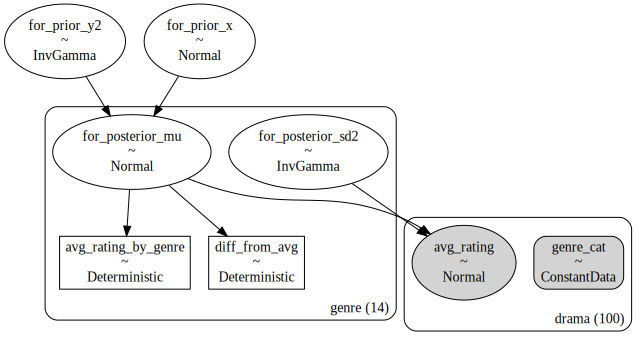

In [88]:
# GraphViz image of model structure
model_to_graphviz(model)

In [89]:
# Trace summary table
trace_summary=az.summary(trace, kind="stats", round_to=2)
trace_summary

,mean,sd,hdi_3%,hdi_97%
for_prior_x,8.72,0.15,8.44,9.01
for_posterior_mu[Action],8.70,0.08,8.54,8.84
for_posterior_mu[Business],8.66,0.39,7.89,9.38
for_posterior_mu[Comedy],8.72,0.11,8.52,8.92
for_posterior_mu[Drama],8.72,0.45,7.86,9.57
for_posterior_mu[Food],8.70,0.45,7.86,9.57
for_posterior_mu[Friendship],8.78,0.16,8.48,9.09
for_posterior_mu[Historical],8.72,0.20,8.36,9.10
for_posterior_mu[Horror],8.69,0.33,8.12,9.36
for_posterior_mu[Life],8.77,0.34,8.10,9.40


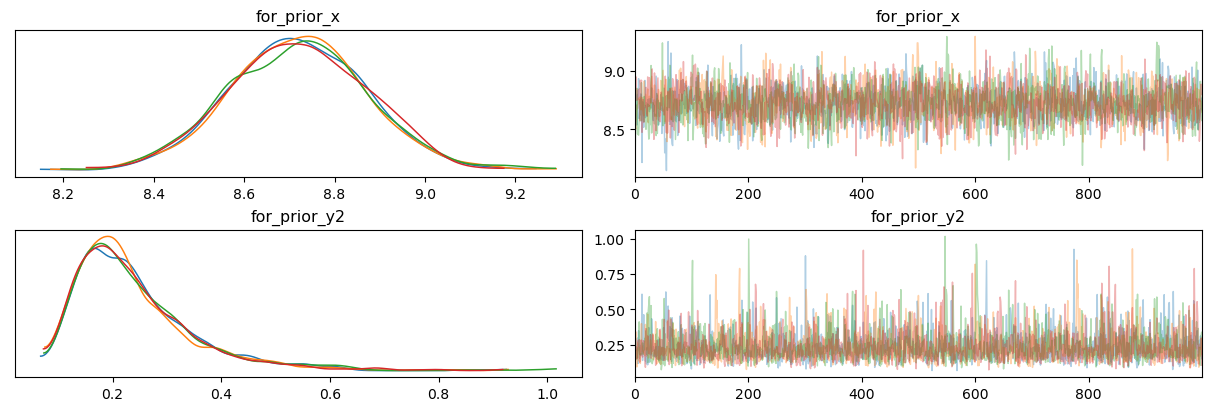

In [92]:
# Trace Plot of Hyper-priors
trace_plot_hyperpriors = az.plot_trace(trace, var_names=["for_prior_x", "for_prior_y2"], compact=False);

C:\Users\anneg\anaconda3\lib\site-packages\arviz\plots\traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (28), generating only 20 plots
  warnings.warn(


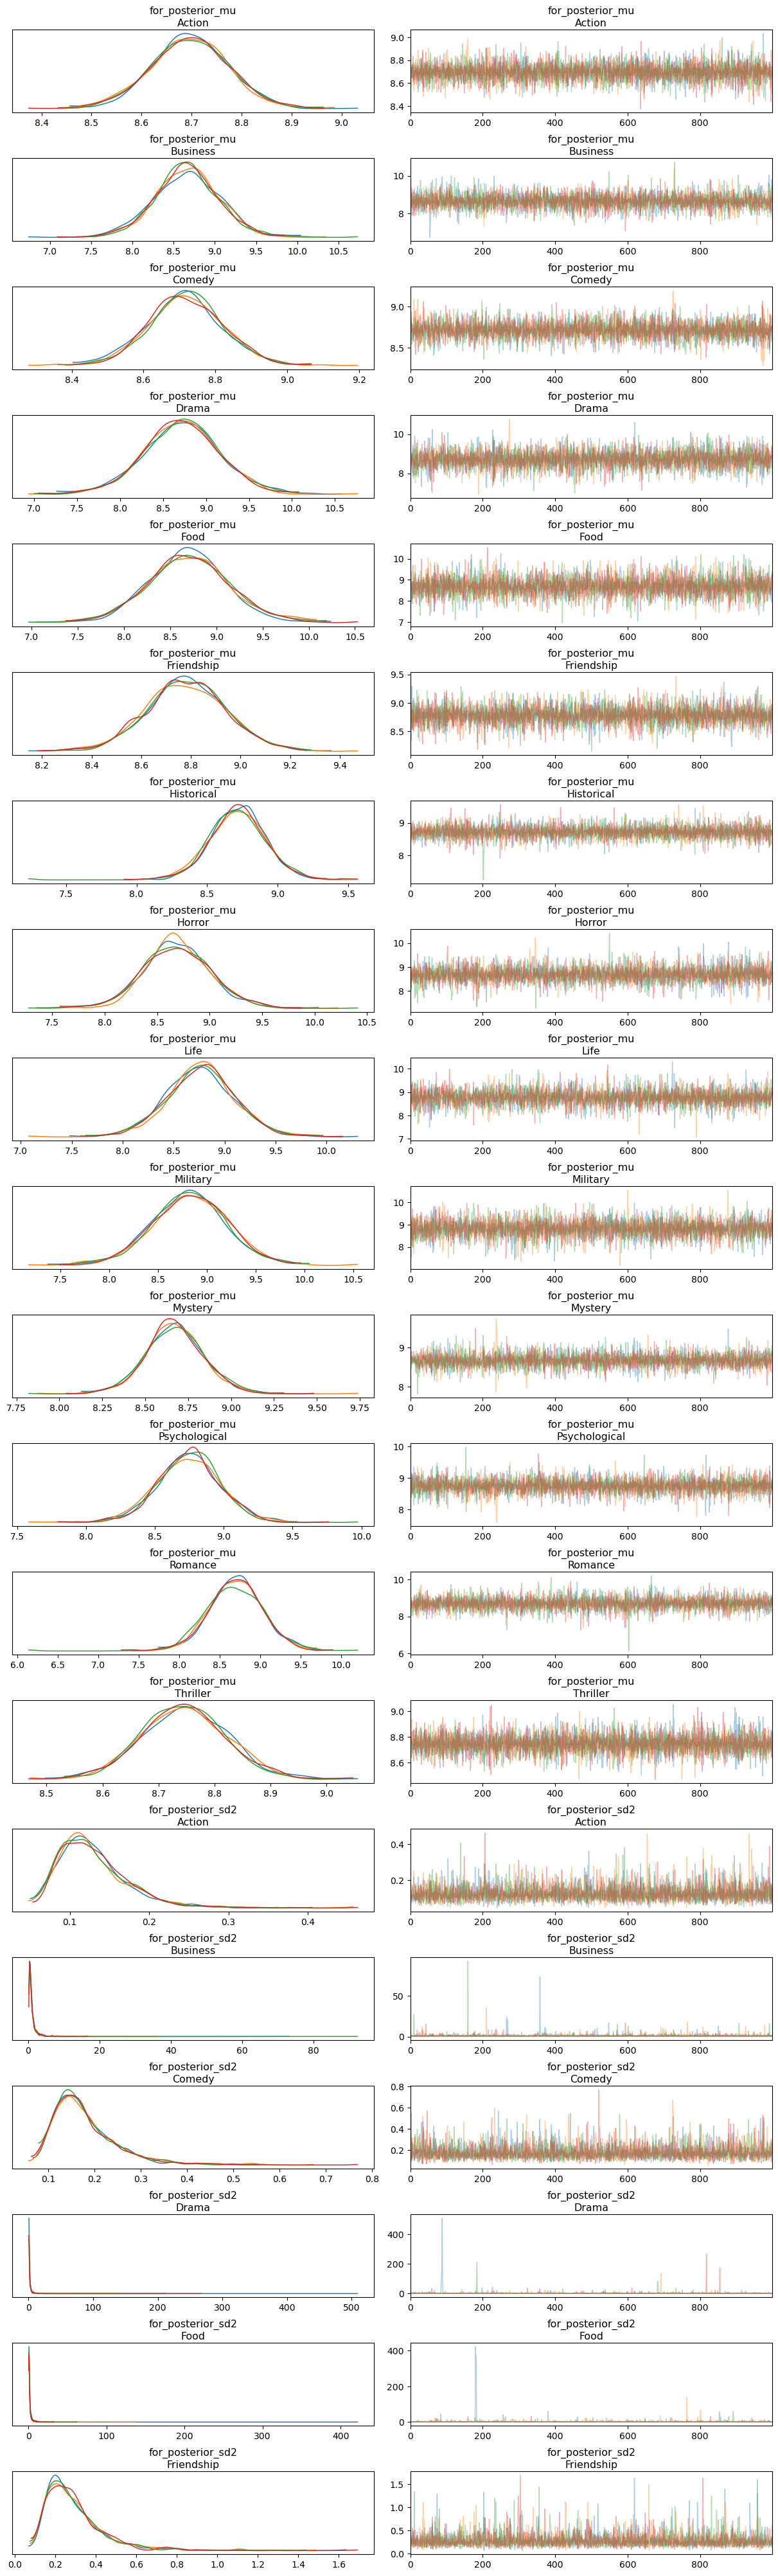

In [93]:
# Trace Plot of Priors
trace_plot_priors = az.plot_trace(trace, var_names=["for_posterior_mu", "for_posterior_sd2"], compact=False);

In [94]:
#az.plot_energy(trace, figsize=(6, 4));

In [95]:
#az.summary(trace, kind="diagnostics")

In [96]:
# not needed in output
# HDI = high-density intervals
# short credible intervals containing the posterior mass in a single figure
trace_hdi = az.hdi(trace)
trace_hdi["avg_rating_by_genre"]

<xarray.DataArray 'avg_rating_by_genre' (genre: 14, hdi: 2)>
array([[8.54449483, 8.84078249],
       [7.89353861, 9.37600063],
       [8.51897153, 8.91621785],
       [7.8563741 , 9.5693491 ],
       [7.85877295, 9.56587577],
       [8.47978487, 9.09046798],
       [8.35544278, 9.1046844 ],
       [8.11943009, 9.35942959],
       [8.10408654, 9.3957261 ],
       [8.08022718, 9.56122628],
       [8.35692058, 9.01606943],
       [8.32695985, 9.18140876],
       [8.08805014, 9.36915648],
       [8.60719138, 8.89327079]])
Coordinates:
  * genre    (genre) <U13 'Action' 'Business' 'Comedy' ... 'Romance' 'Thriller'
  * hdi      (hdi) <U6 'lower' 'higher'

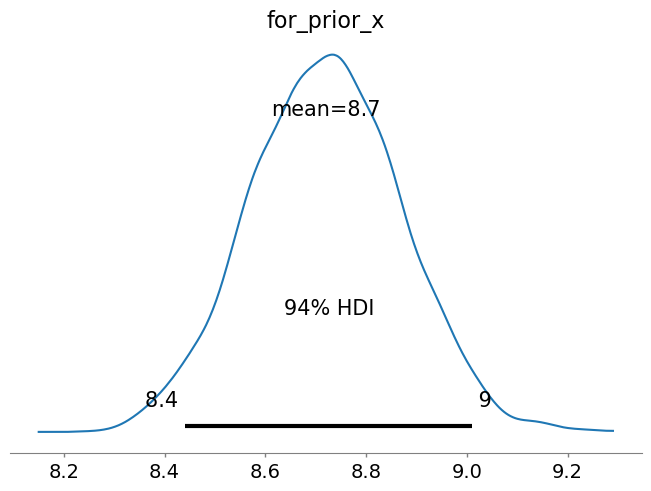

In [123]:
az.plot_posterior(trace, var_names=["for_prior_x"]);

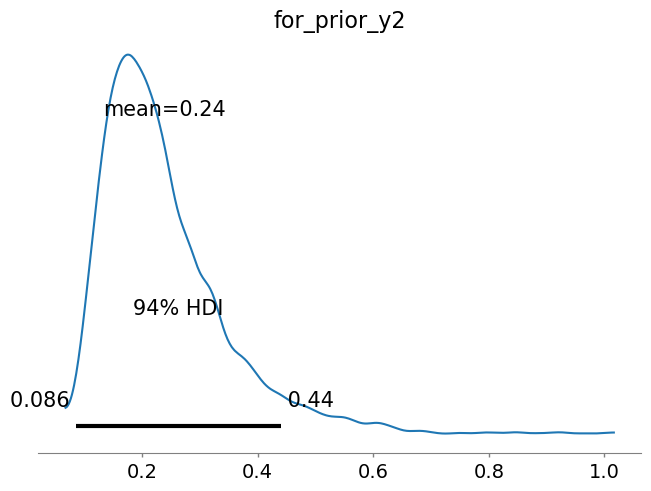

In [124]:
az.plot_posterior(trace, var_names=["for_prior_y2"]);

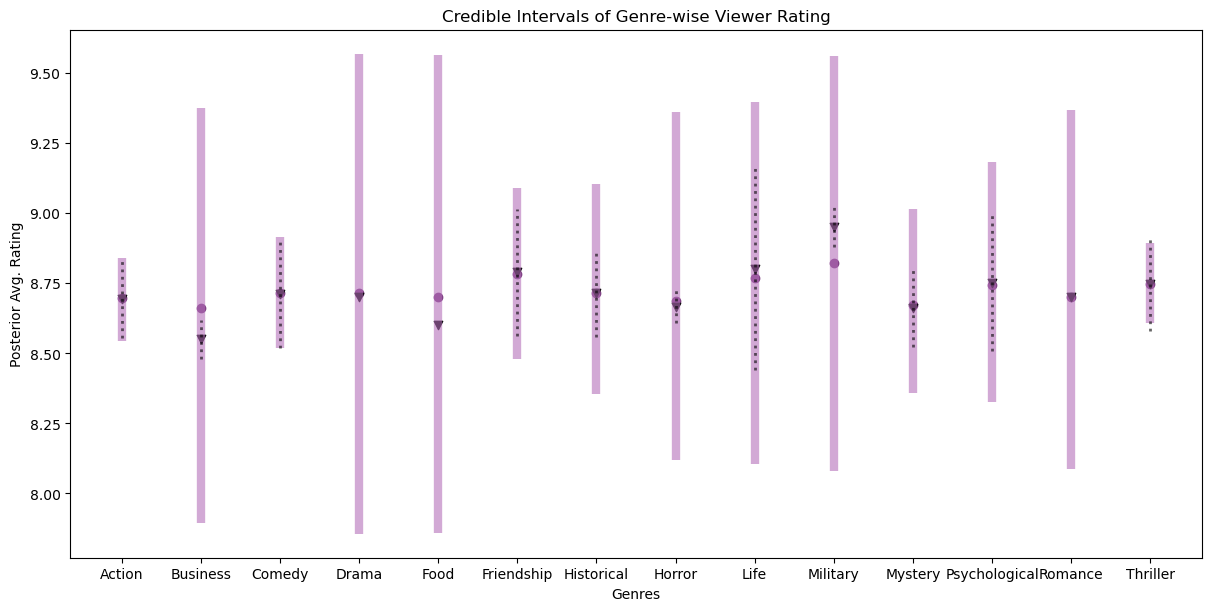

In [97]:
# Plot 1

_, ax = plt.subplots(figsize=(12, 6))

ax.scatter(genres, trace.posterior["avg_rating_by_genre"].mean(dim=("chain", "draw")), color=colors[6])
ax.vlines(
    genres,
    trace_hdi["avg_rating_by_genre"].sel({"hdi": "lower"}),
    trace_hdi["avg_rating_by_genre"].sel({"hdi": "higher"}),
    color=colors[5],
    lw=6,
    alpha=0.6,
)

ax.scatter(genre_stats.genre_simple, genre_stats.Mean, color="black",marker="v")
ax.vlines(
    genre_stats.genre_simple,
    genre_stats.Mean - genre_stats.SD,
    genre_stats.Mean + genre_stats.SD,
    color="black",
    lw=2,
    alpha=0.6,
    linestyles='dotted'
)

ax.set_xlabel("Genres")
ax.set_ylabel("Posterior Avg. Rating")
ax.set_title("Credible Intervals of Genre-wise Viewer Rating");

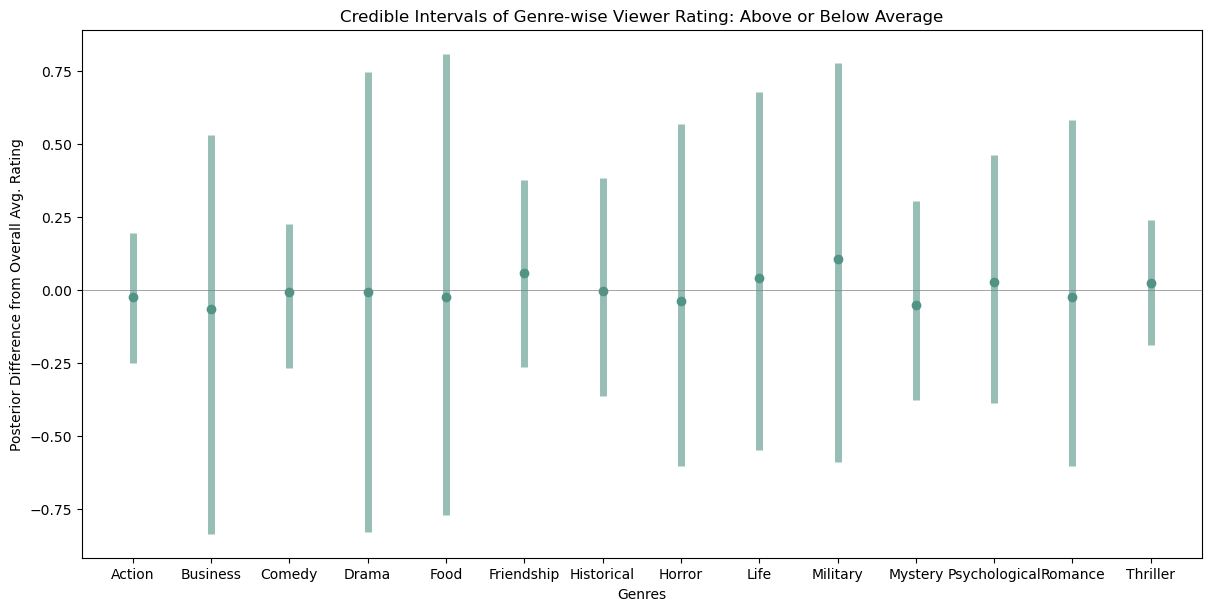

In [98]:
# Plot 2

_, ax = plt.subplots(figsize=(12, 6))

ax.scatter(genres, trace.posterior["diff_from_avg"].median(dim=("chain", "draw")), color=colors[4])
ax.vlines(
    genres,
    trace_hdi["diff_from_avg"].sel({"hdi": "lower"}),
    trace_hdi["diff_from_avg"].sel({"hdi": "higher"}),
    color=colors[4],
    lw=5,
    alpha=0.6,
)
ax.axhline(0, color="grey",lw=.5,)
ax.set_xlabel("Genres")
ax.set_ylabel("Posterior Difference from Overall Avg. Rating")
ax.set_title("Credible Intervals of Genre-wise Viewer Rating: Above or Below Average");

In [ ]:
##########################################
###### -try uniform hyper-priors / priors
##### -get model graph to work
##### -figure out what Deterministic and ConstantData are
#########################################

#### Diffuse Priors, with NUTS sampler:

In [109]:
# diffuse priors
# μj ~ Normal(x, y)
# σ^2 ~ Uniform(a,b)
a_=1
b_=25

# diffuse Hyperpriors:
# x ~ Uniform(c,d)
# y^2 ~ Uniform(e,f)
c_=1
d_=10
e_=1
f_=25

In [111]:
with pm.Model(coords=coords) as model_diffuse:
    # constant data
    genre_cat = pm.ConstantData("genre_cat", genre_idx, dims="drama") # Data container that registers a data variable with the model as a tensor
    # add 'dims' in?

    #dims : str or tuple of str, optional
        #Dimension names of the random variables (as opposed to the shapes of these
        #random variables). Use this when ``value`` is a pandas Series or DataFrame. The
        #``dims`` will then be the name of the Series / DataFrame's columns. See ArviZ
        #documentation for more information about dimensions and coordinates:
        #:ref:`arviz:quickstart`.
        #If this parameter is not specified, the random variables will not have dimension
        #names.
    
    
    # Hyperpriors:
    # x ~ Uniform(c,d)
    # y^2 ~ Uniform(e,f)
    for_prior_x = pm.Uniform("for_prior_x", lower=c_, upper=d_)  # assign c and d
    for_prior_y2 = pm.Uniform("for_prior_y2", lower=e_, upper=f_)  # assign e and f
    
    # priors / genre-specific parameters:
    # μj ~ Normal(x, y)
    # σ^2 ~ Uniform(a,b)
    for_posterior_mu = pm.Normal("for_posterior_mu", mu=for_prior_x, sigma=pt.sqrt(for_prior_y2), dims="genre")
    for_posterior_sd2=pm.Uniform("for_posterior_sd2",lower=a_, upper=b_, dims="genre") #define a and b
        
    # Create a named deterministic variable
    # ?????
    avg_rating_by_genre_diffuse = pm.Deterministic("avg_rating_by_genre", for_posterior_mu, dims="genre")
    diff_from_avg_diffuse = pm.Deterministic("diff_from_avg", for_posterior_mu - pt.mean(for_posterior_mu), dims="genre")
    
   
    # Expected value per genre:
    genre_avg_rating_diffuse = for_posterior_mu[genre_idx]
    genre_sd_rating_diffuse = pt.sqrt(for_posterior_sd2[genre_idx])
    
    
    # likelihood of observed data
    avg_rating_diffuse = pm.Normal(
        "avg_rating",
        mu=genre_avg_rating_diffuse,   #separate mean for each genre
        sigma=genre_sd_rating_diffuse,  #shared stdev across all genres
        observed=data["Rating"],
        dims=("drama"),
    )
    

    # Uses NUTS sampler
    # see https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sample.html

    trace_diffuse = pm.sample(1000, tune=1500, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [for_prior_x, for_prior_y2, for_posterior_mu, for_posterior_sd2]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 32 seconds.


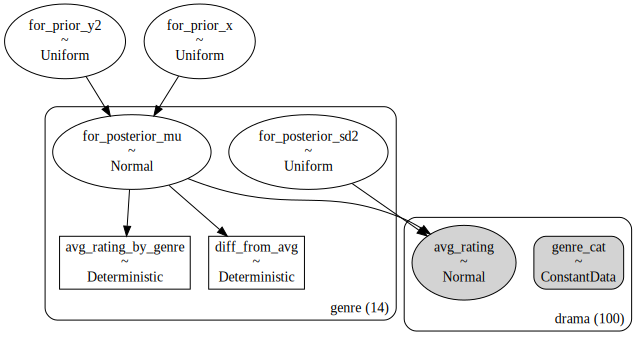

In [112]:
model_to_graphviz(model_diffuse)

In [117]:
# not needed in output
# HDI = high-density intervals
# short credible intervals containing the posterior mass in a single figure
trace_hdi_diffuse = az.hdi(trace_diffuse)
trace_hdi_diffuse["avg_rating_by_genre"]

<xarray.DataArray 'avg_rating_by_genre' (genre: 14, hdi: 2)>
array([[ 8.25175258,  9.18173324],
       [ 6.73734415, 10.4639041 ],
       [ 8.22477195,  9.23698036],
       [ 6.61322651, 10.74645809],
       [ 6.53785816, 10.76205191],
       [ 8.05710489,  9.51187197],
       [ 7.82113228,  9.56771519],
       [ 7.06074076, 10.14959485],
       [ 7.17756902, 10.32873762],
       [ 6.95537599, 10.6801194 ],
       [ 7.83041887,  9.42854046],
       [ 7.75209977,  9.70295301],
       [ 7.03795552, 10.28264948],
       [ 8.32326447,  9.15293289]])
Coordinates:
  * genre    (genre) <U13 'Action' 'Business' 'Comedy' ... 'Romance' 'Thriller'
  * hdi      (hdi) <U6 'lower' 'higher'

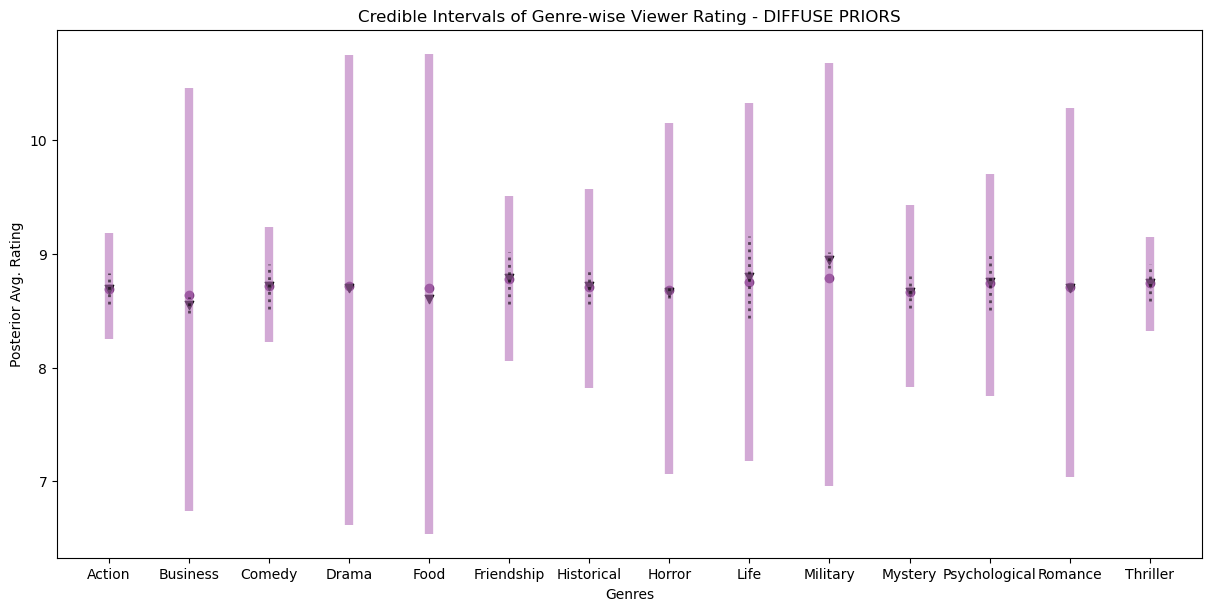

In [119]:
_, ax = plt.subplots(figsize=(12, 6))

ax.scatter(genres, trace_diffuse.posterior["avg_rating_by_genre"].mean(dim=("chain", "draw")), color=colors[6])
ax.vlines(
    genres,
    trace_hdi_diffuse["avg_rating_by_genre"].sel({"hdi": "lower"}),
    trace_hdi_diffuse["avg_rating_by_genre"].sel({"hdi": "higher"}),
    color=colors[5],
    lw=6,
    alpha=0.6,
)

ax.scatter(genre_stats.genre_simple, genre_stats.Mean, color="black",marker="v")
ax.vlines(
    genre_stats.genre_simple,
    genre_stats.Mean - genre_stats.SD,
    genre_stats.Mean + genre_stats.SD,
    color="black",
    lw=2,
    alpha=0.6,
    linestyles='dotted'
)

ax.set_xlabel("Genres")
ax.set_ylabel("Posterior Avg. Rating")
ax.set_title("Credible Intervals of Genre-wise Viewer Rating - DIFFUSE PRIORS");

#### Another Weakly Informative Prior, with NUTS sampler:

In [120]:
# priors
# μj ~ Normal(x, y)
# σ^2 ~ InverseGamma(a,b)
av=1
bv=1

# Hyperpriors:
# x ~ Normal(c,d)
# y^2 ~ InverseGamma(e,f)
cv=8.7
dv=.5
ev=1
fv=1

In [121]:
with pm.Model(coords=coords) as model_v2:
    # constant data
    genre_cat = pm.ConstantData("genre_cat", genre_idx, dims="drama") # Data container that registers a data variable with the model as a tensor
    # add 'dims' in?

    #dims : str or tuple of str, optional
        #Dimension names of the random variables (as opposed to the shapes of these
        #random variables). Use this when ``value`` is a pandas Series or DataFrame. The
        #``dims`` will then be the name of the Series / DataFrame's columns. See ArviZ
        #documentation for more information about dimensions and coordinates:
        #:ref:`arviz:quickstart`.
        #If this parameter is not specified, the random variables will not have dimension
        #names.
    
    
    # Hyperpriors:
    # x ~ Normal(c,d)
    # 1/y^2 ~ Gamma(e,f)
    for_prior_x = pm.Normal("for_prior_x", mu=cv, sigma=dv)  # assign c and d
    for_prior_y2 = pm.Gamma("for_prior_y2", alpha=ev, beta=fv)  # assign e and f
    
    # priors / genre-specific parameters:
    # μj ~ Normal(x, y)
    # 1/σ^2 ~ Gamma(a,b)
    for_posterior_mu = pm.Normal("for_posterior_mu", mu=for_prior_x, sigma=pt.reciprocal(pt.sqrt(for_prior_y2)), dims="genre")
    for_posterior_sd2=pm.Gamma("for_posterior_sd2",alpha=av, beta=bv, dims="genre") #define a and b
        
    # Create a named deterministic variable
    # ?????
    avg_rating_by_genre = pm.Deterministic("avg_rating_by_genre", for_posterior_mu, dims="genre")
    diff_from_avg = pm.Deterministic("diff_from_avg", for_posterior_mu - pt.mean(for_posterior_mu), dims="genre")
    
   
    # Expected value per genre:
    genre_avg_rating = for_posterior_mu[genre_idx]
    genre_sd_rating = pt.reciprocal(pt.sqrt(for_posterior_sd2))[genre_idx]
    
    
    # likelihood of observed data
    avg_rating = pm.Normal(
        "avg_rating",
        mu=genre_avg_rating,   #separate mean for each genre
        sigma=genre_sd_rating,  #shared stdev across all genres
        observed=data["Rating"],
        dims=("drama"),
    )
    

    # Uses NUTS sampler
    # see https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sample.html
    trace_v2 = pm.sample(1000, tune=1500, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [for_prior_x, for_prior_y2, for_posterior_mu, for_posterior_sd2]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 32 seconds.


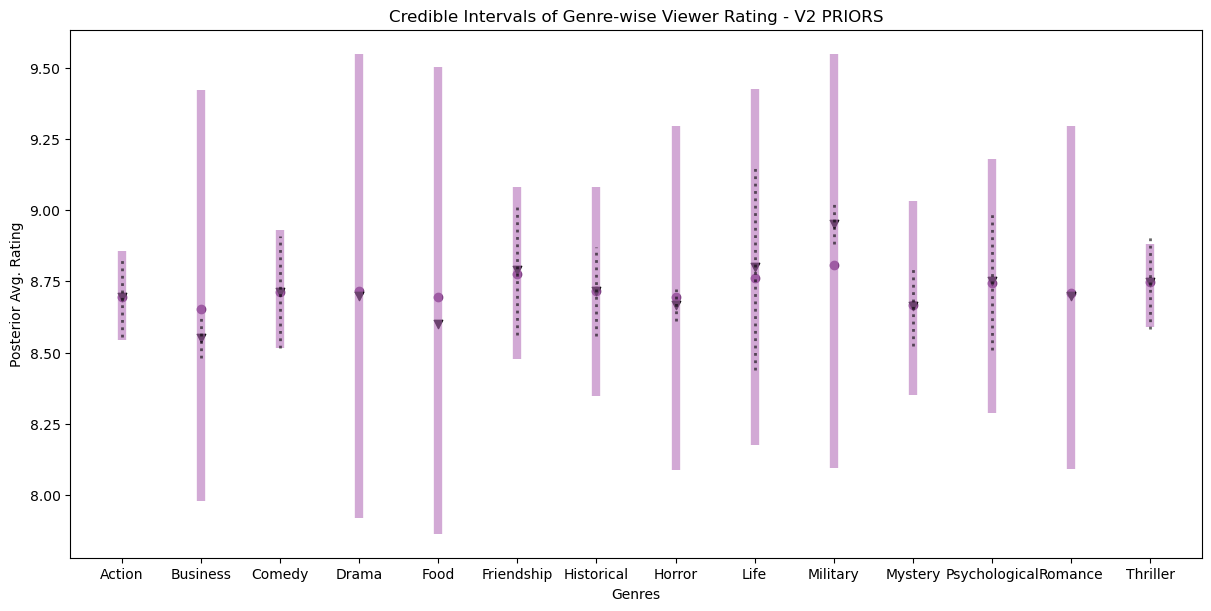

In [122]:
trace_hdi_v2 = az.hdi(trace_v2)
trace_hdi_v2["avg_rating_by_genre"]


_, ax = plt.subplots(figsize=(12, 6))

ax.scatter(genres, trace_v2.posterior["avg_rating_by_genre"].mean(dim=("chain", "draw")), color=colors[6])
ax.vlines(
    genres,
    trace_hdi_v2["avg_rating_by_genre"].sel({"hdi": "lower"}),
    trace_hdi_v2["avg_rating_by_genre"].sel({"hdi": "higher"}),
    color=colors[5],
    lw=6,
    alpha=0.6,
)

ax.scatter(genre_stats.genre_simple, genre_stats.Mean, color="black",marker="v")
ax.vlines(
    genre_stats.genre_simple,
    genre_stats.Mean - genre_stats.SD,
    genre_stats.Mean + genre_stats.SD,
    color="black",
    lw=2,
    alpha=0.6,
    linestyles='dotted'
)

ax.set_xlabel("Genres")
ax.set_ylabel("Posterior Avg. Rating")
ax.set_title("Credible Intervals of Genre-wise Viewer Rating - V2 PRIORS");

In [106]:
"""
with pm.Model(coords=coords) as model_MH:
    # constant data
    #genre_cat = pm.ConstantData("genre_cat", genre_idx, dims="drama") # Data container that registers a data variable with the model as a tensor
    # add 'dims' in?

    #dims : str or tuple of str, optional
        #Dimension names of the random variables (as opposed to the shapes of these
        #random variables). Use this when ``value`` is a pandas Series or DataFrame. The
        #``dims`` will then be the name of the Series / DataFrame's columns. See ArviZ
        #documentation for more information about dimensions and coordinates:
        #:ref:`arviz:quickstart`.
        #If this parameter is not specified, the random variables will not have dimension
        #names.
    
    
    # Hyperpriors:
    # x ~ Normal(c,d)
    # y^2 ~ InverseGamma(e,f)
    mu_genre_x = pm.Normal("mu_genre_x", mu=c, sigma=d)  # assign c and d
    sd2_genre_y2 = pm.InverseGamma("sd2_genre_y2", alpha=e, beta=f)  # assign e and f
    #y=sqrt(1/invy2)
    
    # priors / genre-specific parameters:
    # μj ~ Normal(x, y)
    # σ^2 ~ InverseGamma(a,b)
    mu_genre = pm.Normal("mu_genre", mu=mu_genre_x, sigma=sd2_genre_y2, dims="genre")
    sd2_genre=pm.InverseGamma("sd2_genre",alpha=a, beta=b, dims="genre") #define a and b
    #sigma=sqrt(1/invsigma2)
    
    # Create a named deterministic variable
    # ?????
    #avg_rating_by_genre = pm.Deterministic("avg_rating_by_genre", mu_genre, dims="genre")
    #diff_from_avg = pm.Deterministic("diff_from_avg", mu_genre - pt.mean(mu_genre), dims="genre")
    #sd2 = pm.Deterministic("sd2", sd2_genre - pt.mean(sd2_genre), dims="genre")
    
   
    # Expected value per genre:
    genre_avg_rating = mu_genre[genre_idx]
    genre_sd_rating = sd2_genre[genre_idx]
    
    
    # likelihood of observed data
    avg_rating = pm.Normal(
        "avg_rating",
        mu=genre_avg_rating,
        sigma=genre_sd_rating,
        observed=data["Rating"],
        #dims=("drama"),
    )
    

     Uses Metropolis-Hastings sampler
     see https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.Metropolis.html
            Parameters
       ----------
        vars: List of value variables for sampler
        S: standard deviation or covariance matrix
            Some measure of variance to parameterize proposal distribution
        proposal_dist: Function that returns zero-mean deviates when parameterized with S (and n). Defaults to normal.
        scaling: Initial scale factor for proposal. Defaults to 1.
        tune:  Flag for tuning. Defaults to True.
        tune_interval:  The frequency of tuning. Defaults to 100 iterations.
        model:  Optional model for sampling step. Defaults to None (taken from context).
        mode:  compilation mode passed to PyTensor functions

    steps = pm.Metropolis(vars=[mu_genre_x,sd2_genre_y2,mu_genre,sd2_genre],tune_interval=1000)
    trace_MH = pm.sample(1000,step=steps, progressbar=True)
"""

'\nwith pm.Model(coords=coords) as model_MH:\n    # constant data\n    #genre_cat = pm.ConstantData("genre_cat", genre_idx, dims="drama") # Data container that registers a data variable with the model as a tensor\n    # add \'dims\' in?\n\n    #dims : str or tuple of str, optional\n        #Dimension names of the random variables (as opposed to the shapes of these\n        #random variables). Use this when ``value`` is a pandas Series or DataFrame. The\n        #``dims`` will then be the name of the Series / DataFrame\'s columns. See ArviZ\n        #documentation for more information about dimensions and coordinates:\n        #:ref:`arviz:quickstart`.\n        #If this parameter is not specified, the random variables will not have dimension\n        #names.\n    \n    \n    # Hyperpriors:\n    # x ~ Normal(c,d)\n    # y^2 ~ InverseGamma(e,f)\n    mu_genre_x = pm.Normal("mu_genre_x", mu=c, sigma=d)  # assign c and d\n    sd2_genre_y2 = pm.InverseGamma("sd2_genre_y2", alpha=e, beta=f)  #

In [ ]:
# Create requirements.txt file
# 1. open Anaconda powershell
# 2. create empty folder that contains .py file of jupyter notebook
# 3. navigate to the folder `cd "C:\Users\anneg\OneDrive - Logic20 20 Inc\Documents\Python Scripts\reqs"`
# 4. type `pipreqs`
# 5. should create a txt file of packages only used by that notebook